In [1]:
# !pip install numpy requests nlpaug
# !pip install tensformers
# !pip install evaluate
# !pip install tensorboard
# !pip install accelerate -U
# !pip uninstall pillow
# !pip install pillow==9.4.0
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from transformers import AutoTokenizer
import evaluate
from sklearn.model_selection import train_test_split
import os
import shutil

from transformers import  DataCollatorWithPadding
from datasets import  load_metric
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import BertTokenizer,BertForSequenceClassification
import time
import datetime
import random
from transformers import get_linear_schedule_with_warmup


/home/user/albaredh0/miniconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:

torch.cuda.empty_cache()


In [4]:

def getlen(x):
    return len(x)

df=pd.read_csv('../train-balanced-sarcasm.csv')

df["lengths"]=df["comment"].astype(str).map(getlen)
filtered_rows = df[df["lengths"] < 90]
labels=filtered_rows["label"].to_list()

comments=filtered_rows["comment"].astype(str).to_list()


In [5]:
len(comments),len(labels)

(841998, 841998)

In [6]:

# Using groupby() and count()
# df2 = filtered_rows.groupby(['lengths'])['lengths'].count()
# print(df2)


In [7]:

# x_train, x_test_valid, y_train, y_test_valid = train_test_split(comments, labels, test_size=0.33, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(comments, labels, test_size=0.3, random_state=42)

# x_test, x_valid, y_test, y_valid = train_test_split(x_test_valid, y_test_valid, test_size=0.5, random_state=42)

In [8]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [9]:



tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.to(device)
     
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [10]:
max_len = 0

# For every sentence...
for sent in x_train:

    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  74


In [11]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [12]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [13]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,encodings,labels):
      self.encodings=encodings
      self.labels=labels   
    def __len__(self):
        return len(self.encodings)    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item                   
# train_encodings = tokenizer(x_train, truncation=True, padding=True,   add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = max_length, 
#                         return_attention_mask = True,   
#                         return_tensors = 'pt')
# val_encodings = tokenizer(x_valid, truncation=True, padding=True,   add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = max_length,           
#                         return_attention_mask = True,   
#                         return_tensors = 'pt',)
# train_dataset=CustomDataset(train_encodings,labels=y_train)
# eval_dataset=CustomDataset(val_encodings,labels=y_valid)

# train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
# eval_dataloader=torch.utils.data.DataLoader(eval_dataset)


In [14]:

# accuracy = evaluate.load("accuracy")
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
metric = load_metric("accuracy")
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    print(eval_pred)
    predictions = np.argmax(logits, axis=-1)
    return clf_metrics.compute(predictions=predictions, references=labels)

/tmp/ipykernel_939829/1095326393.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


### new code

In [16]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
# For every sentence...
for sent in comments:

    encoded_dict = tokenizer.encode_plus(
                       sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]
                        pad_to_max_length = True,
                        max_length=100,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt'     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

/home/user/albaredh0/miniconda3/envs/myenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 64
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            # sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            shuffle=True
        )
# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            # sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [19]:
def save_model(model,path):
 torch.save(model.state_dict(), path)
import json
def save_stats(training_stats,file_path):
    with open(file_path, 'w') as json_file:
        json.dump(training_stats, json_file) 

In [20]:
from transformers import get_linear_schedule_with_warmup
epochs = 8
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [21]:
import random
def train_model(model,train_dataloader,validation_dataloader,epochs):
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []
    # Measure the total training time for the whole run.
    total_t0 = time.time()
    # For each epoch...
    for epoch_i in range(0, epochs):
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        # Measure how long the training epoch takes.
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_train_loss = 0
        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            # Progress update every 40 batches.
            if step % 200 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        
            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
            loss, logits=output.loss,output.logits
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()
            # Update the learning rate.
            scheduler.step()
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.
        print("")
        print("Running Validation...")
        t0 = time.time()
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()
        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        # Evaluate data for one epoch
        for batch in validation_dataloader:            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                output = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            loss, logits=output.loss,output.logits    
            # Accumulate the validation loss.
            total_eval_loss += loss.item()
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
        save_stats(training_stats=training_stats,file_path=f'stats_{epoch_i}.json')
        save_model(model=model,path=f'bert_{epoch_i}.pth')
    print("")
    print("Training complete!")
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


In [22]:
# model.load_state_dict(torch.load("bert.pth"))
# model = BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased")
# model.load_state_dict(torch.load("bert.pth"))
# model=model.to(device)
# # model=model.load_state_dict(torch.load("bert.pth"))
# train_model(train_dataloader=train_dataloader,epochs=5,model=model,validation_dataloader=validation_dataloader)

In [23]:
def train_epoch(model, train_loader, optimizer,scheduler, epoch):
        loss_list = []
        print("")
        print('Training...')
        # Measure how long the training epoch takes.
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_train_loss = 0
        model.train()
        # For each batch of training data...
        for step, batch in enumerate(train_loader):
            # Progress update every 40 batches.
            if step % 1000 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()        
            output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
            loss, logits=output.loss,output.logits
            loss_list.append(loss.item())
            total_train_loss += loss.item()
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_dataloader)            
        training_time = format_time(time.time() - t0)
        print(f"Epoch: {epoch+1} ")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))    
        mean_loss = np.mean(loss_list)
        return mean_loss, loss_list        
    

In [24]:
@torch.no_grad()
def eval_model(model, validation_dataloader):
        # correct = 0
        # total = 0
        loss_list = []
        print("")
        print("Running Validation...")
        t0 = time.time()
        model.eval()
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)            
            output = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            loss, logits=output.loss,output.logits  
            total_eval_loss += loss.item()
            loss_list.append(loss.item())
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # preds = torch.argmax(logits, dim=1)
            # correct += len( torch.where(preds==b_labels)[0])
            # 
            # pred_flat = np.argmax(logits, axis=1).flatten()
            # labels_flat = label_ids.flatten()
            # correct +=np.sum(pred_flat == labels_flat)
            # 
            # total += len(labels)
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            
        # accuracy = correct / total * 100
        loss = np.mean(loss_list)
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        validation_time = format_time(time.time() - t0)
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))
        return avg_val_accuracy, loss


In [25]:
def train_model2(model, optimizer, scheduler, train_loader, valid_loader, num_epochs):   
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    for epoch in range(num_epochs): 
 
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer, 
                epoch=epoch,scheduler=scheduler
            ) 
        accuracy, loss = eval_model(
                    model=model, validation_dataloader=valid_loader
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)       
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"    Train loss: {round(mean_loss, 5)}")
        print(f"    Valid loss: {round(loss, 5)}")
        print(f"    Accuracy: {accuracy}%")
        print("\n")   
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc

In [26]:
train_loss, val_loss, loss_iters, valid_acc=train_model2(model=model,optimizer=optimizer,scheduler=scheduler,train_loader=train_dataloader,
            valid_loader=validation_dataloader,num_epochs=epochs)


Training...
  Batch 1,000  of  9,210.    Elapsed: 0:05:49.
  Batch 2,000  of  9,210.    Elapsed: 0:11:46.
  Batch 3,000  of  9,210.    Elapsed: 0:17:39.
  Batch 4,000  of  9,210.    Elapsed: 0:23:33.
  Batch 5,000  of  9,210.    Elapsed: 0:29:27.
  Batch 6,000  of  9,210.    Elapsed: 0:35:21.
  Batch 7,000  of  9,210.    Elapsed: 0:41:14.
  Batch 8,000  of  9,210.    Elapsed: 0:47:08.
  Batch 9,000  of  9,210.    Elapsed: 0:53:02.
Epoch: 1 
  Average training loss: 0.51
  Training epcoh took: 0:54:16

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.49
  Validation took: 0:07:48
Epoch 1/8
    Train loss: 0.51473
    Valid loss: 0.48818
    Accuracy: 0.7626814216945963%



Training...
  Batch 1,000  of  9,210.    Elapsed: 0:05:54.
  Batch 2,000  of  9,210.    Elapsed: 0:11:47.
  Batch 3,000  of  9,210.    Elapsed: 0:17:41.
  Batch 4,000  of  9,210.    Elapsed: 0:23:35.
  Batch 5,000  of  9,210.    Elapsed: 0:29:29.
  Batch 6,000  of  9,210.    Elapsed: 0:35:23.
  Batch 7,000

In [27]:
x={"train_loss":train_loss, "val_loss":val_loss, "loss_iters":loss_iters,"valid_acc": valid_acc}

In [28]:
save_stats(file_path="stats_training.json",training_stats=x)

In [29]:
save_model(model=model,path="model21.pth")

In [30]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return
import matplotlib.pyplot as plt

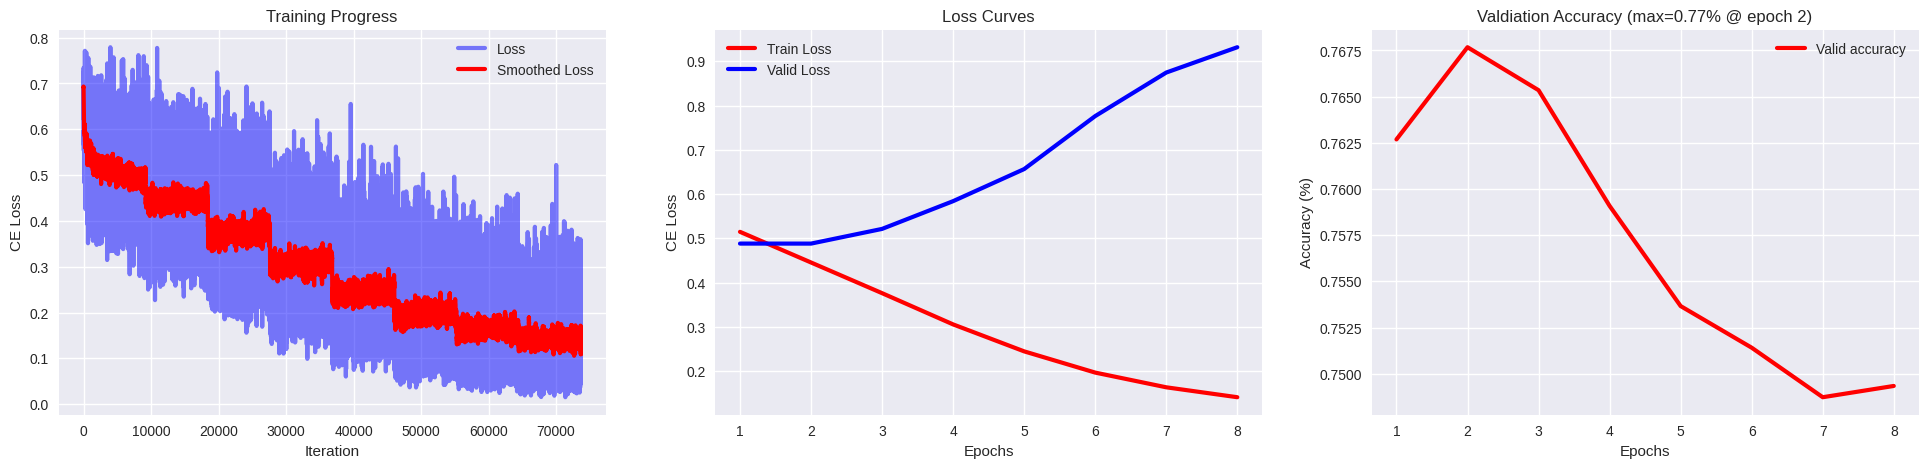

In [31]:


plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

